
#### This dataset includes the locations of businesses that pay taxes to the City and County of San Francisco. Each registered business may have multiple locations and each location is a single row. 

#### The purpose of the analysis here is to understand which industries are most popular in San Francisco area and have most growth potential associated

In [1]:
## Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas.tools import sjoin
import folium
from folium.plugins import MarkerCluster
import shapely
import zipcode
%matplotlib notebook

#### Read dataset

In [2]:
data = pd.read_csv('sfbusinessdataset.csv',encoding = "ISO-8859-1")
data.columns.values

array(['Location Id', 'Business Account Number', 'Ownership Name',
       'DBA Name', 'Street Address', 'City', 'State', 'Source Zipcode',
       'Business Start Date', 'Business End Date', 'Location Start Date',
       'Location End Date', 'Mail Address', 'Mail City', 'Mail Zipcode',
       'Mail State', 'NAICS Code', 'NAICS Code Description',
       'Parking Tax', 'Transient Occupancy Tax', 'LIC Code',
       'LIC Code Description', 'Supervisor District',
       'Neighborhoods - Analysis Boundaries', 'Business Corridor',
       'Business Location'], dtype=object)

In [41]:
data.head()

,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,...,NAICS Code,NAICS Code Description,Parking Tax,Transient Occupancy Tax,LIC Code,LIC Code Description,Supervisor District,Neighborhoods - Analysis Boundaries,Business Corridor,Business Location
0,0026883-11-001,26883,Chevron Texaco Corp,Chevron,2998 San Jose Av,San Francisco,CA,94112.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,11.0,Oceanview/Merced/Ingleside,NaN,"2998 SAN JOSE AV\rSan Francisco, CA 94112\r(37..."
1,0026883-12-001,26883,Chevron Texaco Corp,Chevron,301 Claremont Blvd,San Francisco,CA,94127.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,7.0,West of Twin Peaks,NaN,"301 CLAREMONT BLVD\rSan Francisco, CA 94127\r(..."
2,0026883-13-001,26883,Chevron Texaco Corp,Chevron,3675 Geary Blvd,San Francisco,CA,94118.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,1.0,Lone Mountain/USF,NaN,"3675 GEARY BLVD\rSan Francisco, CA 94118\r(37...."
3,0026883-15-001,26883,Chevron Texaco Corp,Chevron,2301 Lombard St,San Francisco,CA,94123.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,2.0,Marina,NaN,"2301 LOMBARD ST\rSan Francisco, CA 94123\r(37...."
4,0026883-16-001,26883,Chevron Texaco Corp,Chevron,1288 19th St,San Francisco,CA,94107.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,10.0,Potrero Hill,NaN,"1288 19TH ST\rSan Francisco, CA 94107\r(37.761..."


#### Since the analysis asks for insights around San Francisco area, filter for State as 'CA'

In [3]:
data = data[data['State'] == 'CA']

In [13]:
data['City'].value_counts()[0:8]

San Francisco    154082
San+francisco     14398
Oakland            4072
Daly+city          2605
San+jose           1741
Hayward            1233
Richmond           1184
Sacramento         1061
Name: City, dtype: int64

All cities which are part of CA lie around San Francisco area and hence, have to be considered as part of the analysis

#### Q1) Which pockets in San Francisco have higher concentrations of active businesses?

To get businesses which are still active:
-  Filter for businesses with 'NA' as **Business End Date**
-  Filter for businesses with 'NA' as **Location End Date**

This can help determine all businesses which are still running at a particular location


In [17]:
# Filter for active businesses
mask = data['Business End Date'].isnull()
active_business = data[mask]
mask = active_business['Location End Date'].isnull()
active_business = active_business[mask]

To get locations for all the active businesses:
-  Get longitude, latitude details from **Business Location**
-  To fill missing information, get latitude, longitude information from **Source Zipcode** (zipcodes)
    

#### Splitting Business Location column to get latitude, longitude information

In [18]:
active_business['Business Location'] = active_business['Business Location'].astype(str)
# Split column on basis of '\r' seperator and fetch 3rd string
test1 = active_business['Business Location'].map(lambda x: x.split('\r'))
def create_latlong(x):
    if len(x) == 3:
        # return lat-long for all strings with full address
        return x[2]
    
active_business['latlong'] = test1.apply(create_latlong)

In [19]:
# Replace empty cells with NA
active_business['latlong'].replace(r'\s+',np.nan,inplace = True,regex = True)

#### Obtaining latitude, longitude information from Zipcodes

In [20]:
# Data type conversions for zipcode column to run zipcode command for obtaining latitude, longitude
source_zipcode = active_business[active_business['Source Zipcode'].notnull()]['Source Zipcode'].astype(int).astype(str)

In [21]:
# To get latitude, longitude from zipcode
def zip_latlong(x):
    if zipcode.isequal(x) == None:
        ### incase of empty cells or invalid zipcodes
        return None
    else:
        return (zipcode.isequal(x).lat,zipcode.isequal(x).lon)

active_business['latlong_zip'] = source_zipcode.apply(zip_latlong)

In [22]:
# For NA in latlong column, fill with latlong information obtained from zipcodes
active_business['latlong'].fillna(active_business['latlong_zip'],inplace = True)

Around ~0.14% of lat, long information for businesses is still missing. 
Since our focus is on areas of higher concentration, the small percentage of missing data will not sway our analysis much

#### To understand which areas in San Francisco have more concentration of active businesses, the number of active businesses for each latitude, longitude can be plotted on the map

In [23]:
# Determine counts of businesses for each latitude, longitude
df = pd.DataFrame(active_business['latlong'].dropna().value_counts().reset_index())
df.rename(columns = {'index':'lat_long','latlong':'count'},inplace = True,index=str)
df['count'].replace(2220,np.nan,inplace = True,regex = True)
df.dropna(subset = ['count'],inplace = True)

In [24]:
# Store rolled up data in a seperate dataframe
df = pd.DataFrame({'lat':df['lat_long'].map(lambda x: x[0]),'lon':df['lat_long'].map(lambda x: x[1]), 'business_counts':df['count']})

In [13]:
# Function to plot data on California's map
def plot_map(df):
    # generate a new map
    folium_map = folium.Map(location=[37.77, -122.41],
                            zoom_start=10,
                            tiles="CartoDB dark_matter",
                            width='50%')

    # for each row in the data, add a cicle marker
    for index, row in df.iterrows():      
        # generate the popup message that is shown on click.
        popup_text = "Active business counts: {}"
        popup_text = popup_text.format(row['business_counts'])      
        # radius of circles
        radius = row['business_counts']/800
        
        # add marker to the map
        folium.CircleMarker(location=(row["lat"],
                                      row["lon"]),
                            color='#0A8A9F',
                            popup=popup_text,
                            radius = radius,
                            fill=True).add_to(folium_map)
    return folium_map

In [14]:
plot_map(df)

-  The circle size denotes number of active businesses. 
-  The map can be zoomed in to see which areas have most active businesses

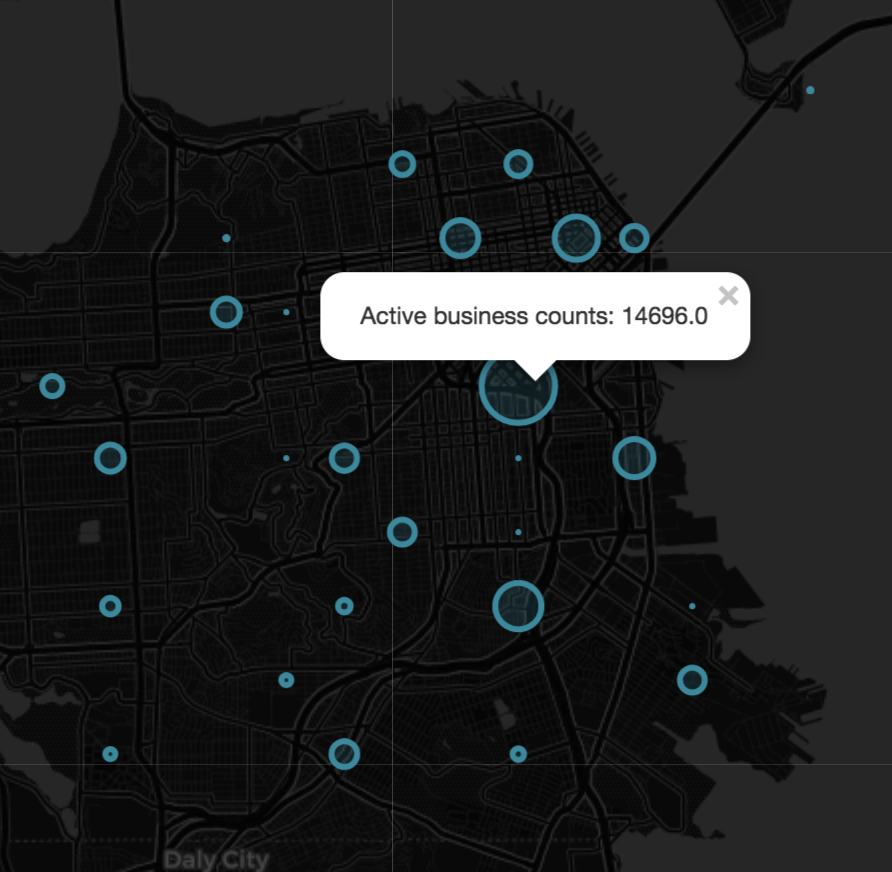

In [42]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "image1.png", width=400, height=300)

The most number of active businesses in a zipcode are located within San Francisco city

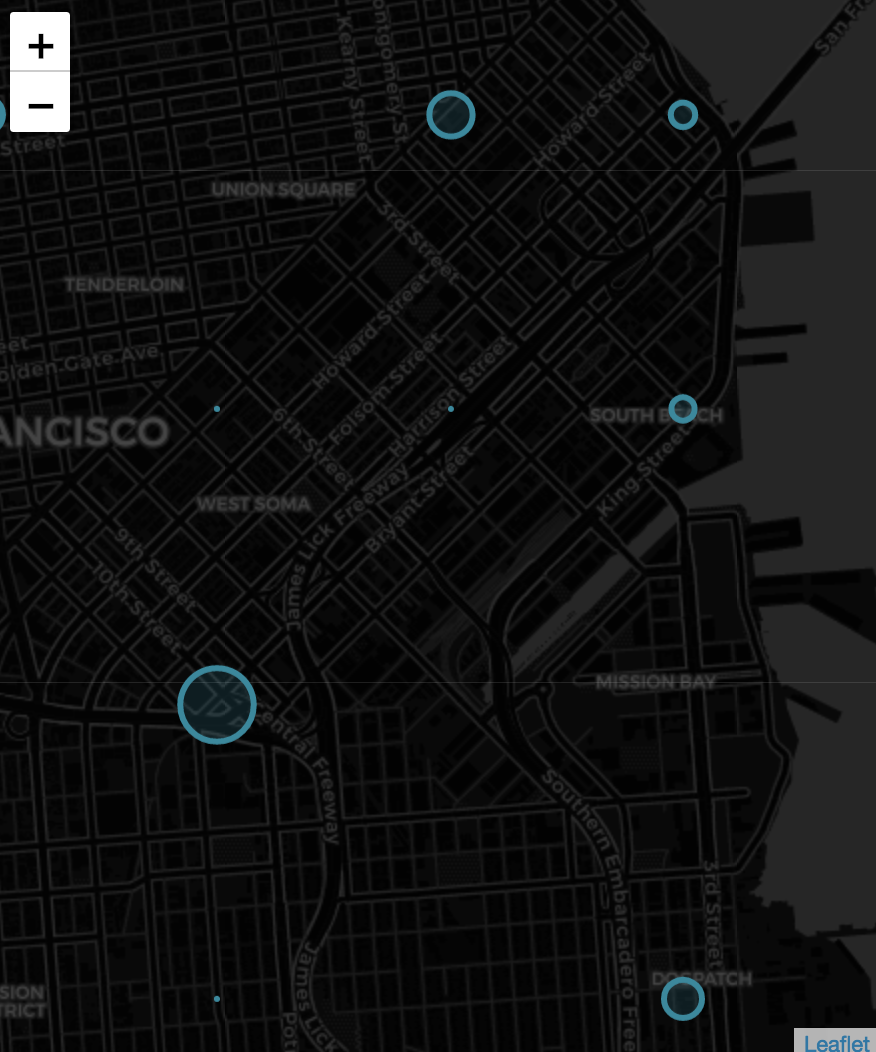

In [33]:
Image(filename = "image2.png", width=400, height=300)

-  The most number of active businesses are 14696 in San Francisco city around Central Freeway
-  Other locations which have most number of active businesses are Union Square, China Market and South beach
-  These areas are commercial hub of the city and hence, have more businesses due to reachability to more customers

#### Q2) Identify the NAICS code and description of businesses that are new and less popular in San Francisco area

To identify businesses for targeting under new tax scheme:
-  Identify number of businesses for each NAICS code to get least popular industry
-  For obtained NAICS codes, understand when were these businesses set up and how many were set up in recent years

#### Get counts of active businesses for each NAICS code

In [26]:
# Removing null NAICS codes as these are unreported values
data1 = active_business[active_business['NAICS Code'].notnull()]
# Active business counts
df = pd.DataFrame(data1['NAICS Code'].value_counts().reset_index())

#### To understand less popular NAICS codes, get business count which fall below 25th percentile

In [27]:
np.percentile(df['NAICS Code'], 25)

1671.0

In [28]:
# Subsetting data to obtain NAICS codes with business counts below 25th percentile
df = df[df['NAICS Code'] <= 1671]
df

,index,NAICS Code
14,3100-3399,1335
15,8100-8399,568
16,5240-5249,452
17,2200-2299,181
18,8110-8139,9


In [30]:
# Get final dataframe with filtered NAICS codes
nonpopular_business = data1[data1['NAICS Code'].isin(df['index'])]

#### Understand number of locations a business opened up in the unpopular NAICS codes

In [31]:
business_counts = pd.DataFrame(nonpopular_business['Business Account Number'].value_counts().reset_index()).rename(columns = {'Business Account Number': 'count',
                                                                                                'index':'Business Account Number'})
business_counts.head()

,Business Account Number,count
0,364434,20
1,394051,12
2,50345,12
3,454332,10
4,451897,9


#### Create a table with first business open date and last business open date along with count of locations a business was opened in to understand which businesses are newer ones

In [33]:
maxdate = pd.DataFrame(nonpopular_business.groupby(['Business Account Number'])['Business Start Date'].max().reset_index())
mindate = pd.DataFrame(nonpopular_business.groupby(['Business Account Number'])['Business Start Date'].min().reset_index())
merged = pd.merge(maxdate,mindate, on=['Business Account Number']).rename(columns = {'Business Start Date_x':'maxdate','Business Start Date_y':'mindate'})
merged = pd.merge(merged,business_counts,on = ['Business Account Number'])[['Business Account Number', 'maxdate','mindate','count']]
merged.head()

,Business Account Number,maxdate,mindate,count
0,780,10/1/1968,10/1/1968,3
1,1072,10/1/1968,10/1/1968,1
2,1341,10/1/1968,10/1/1968,3
3,1495,10/1/1968,10/1/1968,1
4,1775,10/1/1968,10/1/1968,1


In [34]:
# Extract years from dates and create a new column
merged['min_year'] = merged['maxdate'].apply(lambda x: x[-4:])
merged['max_year'] = merged['mindate'].apply(lambda x: x[-4:])
merged = merged[['Business Account Number','min_year','max_year','count']]

#### Get businesses which were opened in last decade

Most of the business in past 6 years have opened up in only 1 location

In [37]:
# Get NAICS code and descriptions of all these businesses
merged = merged[merged['min_year'] >= '2011']
nonpopular_businessnew = nonpopular_business[nonpopular_business['Business Account Number'].isin(merged['Business Account Number'])]

In [38]:
nonpopular_businessnew.groupby(['NAICS Code','NAICS Code Description']).size().reset_index().rename(columns={0:'count'})

,NAICS Code,NAICS Code Description,count
0,2200-2299,Utilities,96
1,3100-3399,Manufacturing,626
2,5240-5249,Insurance,175
3,8100-8399,Certain Services,388
4,8110-8139,Certain Services,7


Among the non-popular NAICS codes extracted, newer industries such as Utilities, Manufacturing and Insurance can benefit the most from government's new tax scheme

#### Q3) What are the different industry types that have come up in San Francisco over the years?

To obtain which industries have sprung up over the years:  
-  For each **NAICS code**(industry), get minimum business start date and maximum business start date to see when the first company in that industry registered and if that industry is still popular  
-  Getting counts for each industry can help understand the total number of registered companies and how popular the industry is  


Here, all business counts are considered as even the non-active businesses can contribute to the industry trend for a particular year

#### Get maximum, minimum dates and business counts for each NAICS code

In [39]:
maxdate = pd.DataFrame(data.groupby(['NAICS Code','NAICS Code Description'])['Business Start Date'].max().reset_index())
mindate = pd.DataFrame(data.groupby(['NAICS Code','NAICS Code Description'])['Business Start Date'].min().reset_index())
merged = pd.merge(maxdate,mindate, on=['NAICS Code','NAICS Code Description']).rename(columns = {'Business Start Date_x': 'maxdate','Business Start Date_y':'mindate'})
new_industry = pd.DataFrame(data['NAICS Code'].value_counts().reset_index()).rename(columns = {'NAICS Code':'count','index':'NAICS Code'})
new_industry = pd.merge(merged,new_industry,on = 'NAICS Code')[['NAICS Code', 'NAICS Code Description','maxdate','mindate','count']]
new_industry

,NAICS Code,NAICS Code Description,maxdate,mindate,count
0,2200-2299,Utilities,9/23/2001,1/1/1993,194
1,2300-2399,Construction,9/9/2016,1/1/1968,11521
2,3100-3399,Manufacturing,9/9/2015,1/1/1969,1607
3,4200-4299,Wholesale Trade,9/9/2015,1/1/1968,3115
4,4400-4599,Retail Trade,9/9/2016,1/1/1958,9959
5,4800-4999,Transportation and Warehousing,9/9/2016,1/1/1969,24744
6,5100-5199,Information,9/9/2016,09/01/1849,2862
7,5210-5239,Financial Services,9/9/2014,1/1/1970,3317
8,5240-5249,Insurance,9/9/2014,1/1/1965,566
9,5300-5399,Real Estate and Rental and Leasing Services,9/9/2016,1/1/1946,20287


-  All industry types except Utility have been existent till now even if the first business started in early 1900s 

In [40]:
# Extract year from minimum date to see which industries came up in recent years
new_industry['start_year'] = new_industry['mindate'].apply(lambda x: x[-4:])
new_industry.sort_values(['start_year'])[['start_year','NAICS Code Description','count']]

,start_year,NAICS Code Description,count
6,1849,Information,2862
11,1897,Administrative and Support Services,2820
9,1946,Real Estate and Rental and Leasing Services,20287
16,1947,Certain Services,817
13,1947,"Arts, Entertainment, and Recreation",5555
12,1948,Private Education and Health Services,5951
10,1957,"Professional, Scientific, and Technical Services",18154
4,1958,Retail Trade,9959
8,1965,Insurance,566
1,1968,Construction,11521


There is a shift observed in the industries types over the years.
-  The earlier industries,i.e. before 1950s were more consumer focussed with services like arts, entertainment, private education, technical services being offered   
-  There has been a small shift towards industrial companies after 1960s with more focus on financial services, trading, manufacturing, transportation which point towards more focus on econmic development and industrialization

This trends makes sense as 1960s saw the American industrialization and a lot of similar industries observed here grew.

#### Q4) What other conclusions can be drawn from the data?

The data here can be further analyzed to add value to both new businesses and government

#### How can further analysis add value to new businesses?

-  Which places within San Francisco county are the most frequent choices for first time business setters?  
    -  This can help understand which locations are most popular among new businesses and location specific attributes can be replicated across rest of the places
    -  This can be achieved by filtering data to get minimum start date for each business along with its location


- The locations obtained can be looked across various industries to understand how industries are distributed across various locations
    -  The location analysis can be broken down by NAICS code to obtain industry distribution


- Analysis about locations where businesses have sprung in recent years can help identify maximum growth areas which is helpful for new businesses

#### How can further analysis add value to government?

There has been recent oppositions regarding parking taxes, to further drill down into the problem:
-  Understand which industries pay most number of parking taxes
-  This can be broken down to LIC codes to further get an insight into the activities where parking taxes are imposed
-  For new business growth, the government can provide rebate in parking tax on certain activities and help businesses understand which activities have parking taxes associated with it